In [1]:
import torch
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import PIL
from torch import optim
from tqdm import tqdm
import time

In [2]:
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
import torch.nn.functional as F

In [3]:
import torchvision.models as models

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device

device(type='cuda', index=0)

In [6]:
torch.__version__

'1.8.1'

In [16]:
real_image_dir = "/home/vajira/data/singan_polyp_checkpoints/real_images"
fake_image_dir = "/work/vajira/DATA/sinGAN_polyps/singan_out"

In [24]:
real_img_path = os.path.join(real_image_dir, "321.jpg")
fake_img_path = os.path.join(fake_image_dir, "chk_id_321_gen_scale_0_0_img.png")

In [25]:
#real_img = cv2.imread(real_img_path) #mage.open(real_img_path)#
#real_img = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
#fake_img = cv2.imread(fake_img_path)
#fake_img = cv2.cvtColor(fake_img, cv2.COLOR_BGR2RGB)

In [26]:
real_img = Image.open(real_img_path)
fake_img = Image.open(fake_img_path)    
fake_img = fake_img.convert("RGB")

In [27]:
#real_img.shape

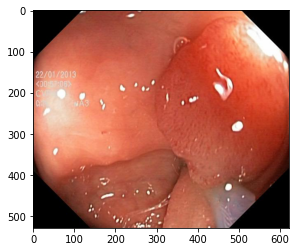

In [28]:
plt.imshow(real_img, vmax=255, vmin=0)

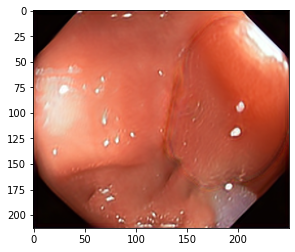

In [29]:
plt.imshow(fake_img, vmax=255, vmin=0)

In [ ]:
fake_img.width

In [ ]:
h, w = fake_img.height, fake_img.width  #256, 384
mean_rgb = (0.485, 0.456, 0.406)
std_rgb = (0.229, 0.224, 0.225)

In [ ]:
transformer = transforms.Compose([
    transforms.Resize((h, w)),
    transforms.ToTensor(),
    transforms.Normalize(mean_rgb, std_rgb)
])

In [ ]:
content_tensor = transformer(fake_img)

In [ ]:
style_tensor = transformer(real_img)

In [ ]:
def imgtensor2pil(img_tensor):
    img_tensor_c = img_tensor.clone().detach()
    img_tensor_c*=torch.tensor(std_rgb).view(3,1,1)
    img_tensor_c+=torch.tensor(mean_rgb).view(3,1,1)
    img_tensor_c = img_tensor_c.clamp(0,1)
    img_pil = to_pil_image(img_tensor_c)
    return img_pil

In [ ]:
plt.imshow(imgtensor2pil(content_tensor))
plt.title("contant image")

In [ ]:
plt.imshow(imgtensor2pil(style_tensor))
plt.title("contant image")

In [ ]:
#model_vgg = models.vgg19(pretrained=True).to(device).eval()

In [ ]:
#model_vgg

In [ ]:
model_vgg = models.vgg16(pretrained=True).features.to(device).eval()

In [ ]:
#type(model_vgg)

In [ ]:
#for name, layer in enumerate(model_vgg.children()):
#    print(layer)

In [ ]:
#list(model_vgg.modules())

In [ ]:
for param in model_vgg.parameters():
    param.requires_grad_(False)

In [ ]:
def get_features(x, model, layers):
    features = {}
    for name, layer in enumerate(model.children()):
        x = layer(x)
        if str(name) in layers:
            features[layers[str(name)]] = x
    return features

In [ ]:
def gram_matrix(x):
    n, c, h, w = x.size()
    x = x.view(n*c, h * w)
    gram = torch.mm(x, x.t())
    return gram

In [ ]:
def get_content_loss(pred_features, target_features, layer):
    target = target_features[layer]
    pred = pred_features[layer]
    loss = F.mse_loss(pred, target)
    return loss

In [ ]:
def get_style_loss(pred_features, target_features, style_layers_dict):
    loss = 0
    for layer in style_layers_dict:
        pred_fea = pred_features[layer]
        pred_gram = gram_matrix(pred_fea)
        n, c, h, w = pred_fea.shape
        target_gram = gram_matrix(target_features[layer])
        layer_loss = style_layers_dict[layer] * F.mse_loss(pred_gram, target_gram)
        loss += layer_loss/ (n* c * h * w)
    return loss
        

In [ ]:
feature_layers = {'0': 'conv1_1',
                   '5': 'conv2_1',
                   '10': 'conv3_1',
                   '19': 'conv4_1',
                   '21': 'conv4_2',
                   '28': 'conv5_1'
                  }

In [ ]:
#for name in feature_layers:
#    print(name)

In [ ]:
con_tensor = content_tensor.unsqueeze(0).to(device)
sty_tensor = style_tensor.unsqueeze(0).to(device)
content_features = get_features(con_tensor, model_vgg, feature_layers)
style_features = get_features(sty_tensor, model_vgg, feature_layers)

In [ ]:
for key in content_features.keys():
    print(content_features[key].shape)

In [ ]:
input_tensor = con_tensor.clone().requires_grad_(True)

In [ ]:

optimizer = optim.Adam([input_tensor], lr=0.01)
#optimizer = optim.LBFGS([input_tensor], lr=0.01)

In [ ]:
num_epochs = 1000
content_weight =10 #1e1
style_weight = 10#1e4
content_layer = "conv5_1"
style_layers_dict = {'conv1_1': 0.75,
                     'conv2_1': 0.5,
                     'conv3_1': 0.25,
                     'conv4_1': 0.25,
                     'conv5_1': 0.25
                  }

In [ ]:
1e1

In [ ]:
%%time
for epoch in range(num_epochs+1):
    optimizer.zero_grad()
    input_features = get_features(input_tensor, model_vgg, feature_layers)
    content_loss = get_content_loss(input_features, content_features, content_layer)
    style_loss = get_style_loss(input_features, style_features, style_layers_dict)
    neural_loss = content_weight * content_loss + style_weight * style_loss
    neural_loss.backward(retain_graph=True)
    optimizer.step()
    if epoch % 100 == 0:
        print('epoch {}, content loss: {:.2}, style loss {:.2}'.format(epoch,content_loss,style_loss))

In [ ]:
plt.imshow(imgtensor2pil(content_tensor))
plt.title("contant image")

In [ ]:
plt.imshow(imgtensor2pil(input_tensor[0].detach().cpu()))

In [ ]:
plt.imshow(imgtensor2pil(style_tensor))

In [ ]:
def transfer_style(content_img: PIL.Image, style_img: PIL.Image, num_epochs: int, content_weight: int, style_weight: int, 
                   device: torch.device, vgg_model:str, *args, **kwargs) -> PIL.Image:
    ''' Trnsfering style from a source image to a target image.
    
    Parameters
    ==========
    
    
    
    Return
    =======
    
    '''
    
    # These values are from VGG implementations
    mean_rgb = (0.485, 0.456, 0.406)
    std_rgb = (0.229, 0.224, 0.225)
    
    # pre-defined values
    feature_layers = {'0': 'conv1_1',
                   '5': 'conv2_1',
                   '10': 'conv3_1',
                   '19': 'conv4_1',
                   '21': 'conv4_2',
                   '28': 'conv5_1'
                  }
    
    content_layer = "conv5_1"
    
    style_layers_dict = {'conv1_1': 0.75,
                         'conv2_1': 0.5,
                         'conv3_1': 0.25,
                         'conv4_1': 0.25,
                         'conv5_1': 0.25
                      }

    
    
    loader = transforms.Compose([
        transforms.Resize((content_img.height,content_img.width)),
        transforms.ToTensor(),
        transforms.Normalize(mean_rgb, std_rgb)
    ])
    
    content_tensor = loader(content_img)
    style_tensor = loader(style_img)
    
    con_tensor = content_tensor.unsqueeze(0).to(device)
    sty_tensor = style_tensor.unsqueeze(0).to(device)
    
    # Model preparation
    model_vgg = getattr(models, vgg_model)(pretrained=True).features.to(device).eval()
    
    for param in model_vgg.parameters():
        param.requires_grad_(False)
        
    input_tensor = con_tensor.clone().requires_grad_(True)
    content_features = get_features(con_tensor, model_vgg, feature_layers)
    style_features = get_features(sty_tensor, model_vgg, feature_layers)
    
    optimizer = optim.Adam([input_tensor], lr=0.01)
    
    
    for epoch in range(num_epochs+1):
        optimizer.zero_grad()
        input_features = get_features(input_tensor, model_vgg, feature_layers)
        content_loss = get_content_loss(input_features, content_features, content_layer)
        style_loss = get_style_loss(input_features, style_features, style_layers_dict)
        neural_loss = content_weight * content_loss + style_weight * style_loss
        neural_loss.backward(retain_graph=True)
        optimizer.step()
        if epoch % 100 == 0:
            print('epoch {}, content loss: {:.2}, style loss {:.2}'.format(epoch,content_loss,style_loss))
    
    
    

In [ ]:
%%time
transfer_style(fake_img, real_img, 1000, content_weight=10, style_weight=10, device = device, vgg_model="vgg16")

In [6]:
from singan_polyp_aug import style_transfer
import os
from PIL import Image
import torch

In [7]:
generated_img_dir = "/work/vajira/DATA/sinGAN_polyps/singan_out"
real_img_dir = "/home/vajira/data/singan_polyp_checkpoints/real_images"

out_dir = "/work/vajira/DATA/sinGAN_polyps/singan_out_style_transfered"

In [8]:
generated_images = os.listdir(generated_img_dir)

In [9]:
real_images = os.listdir(real_img_dir)

In [10]:
real_images[0]

'1000.jpg'

In [11]:
generated_images[0]

'chk_id_321_gen_scale_0_0_mask.png'

Progress: epoch 999, content loss: 0.007, style loss 0.028: 100%|██████████| 1000/1000 [00:05<00:00, 169.12it/s]


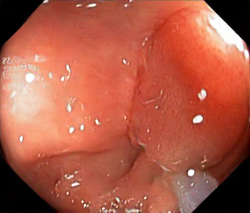

In [30]:
style_transfer.transfer_style(fake_img_path, real_img_path, 1000, content_weight=10, style_weight=10, device = device, vgg_model="vgg16")

In [42]:
def transfer_style_to_folder(generated_img_dir_path, real_img_dir_path,  output_dir, num_epochs: int, content_weight: int, style_weight: int, 
                   device: torch.device, vgg_model:str, verbose=False, *args, **kwargs):
    
    generated_images = os.listdir(generated_img_dir)
    real_images = os.listdir(real_img_dir_path)
    
    os.makedirs(output_dir, exist_ok=True)
    
    generated_images_filtered = [img for img in generated_images if "mask" not in str(img)] # Remove mask images
    
    #print(len(generated_images_filtered))
    
    pbar = tqdm(generated_images_filtered, position= 0, leave=False)
    for gen_img in pbar:
        
        if "mask" in str(gen_img): # To skip masks
            continue
        
        gen_img_id = gen_img.split("_")[2]
        real_img_of_gen_img  = str(gen_img_id) + ".jpg"
        
        gen_img_path = os.path.join(generated_img_dir_path, gen_img)
        real_img_path = os.path.join(real_img_dir_path, real_img_of_gen_img)
        
        pbar.set_description("Processing %s" % gen_img)
        
        time.sleep(2)
        
        #print("gen_img_path=", gen_img_path)
        #print("real_img_path=", real_img_path)
        
        out_img = style_transfer.transfer_style(gen_img_path, real_img_path,
                                 num_epochs, content_weight, style_weight, 
                                 device, vgg_model, verbose, tqdm_position=0, tqdm_leave=False,
                                 *args, **kwargs)
        #return out_img
        
        out_img.save(os.path.join(output_dir, gen_img.split(".")[0] + "_ST" + ".png"))
        
        
        #print(gen_img_id)
    

In [43]:
transfer_style_to_folder(generated_img_dir, real_img_dir,  out_dir, 1000, content_weight=10, style_weight=10, device = device, vgg_model="vgg16")

KeyboardInterrupt: 

In [ ]:
help(transfer_style_to_folder)